In [1]:
import string
from sympy import solve, Matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgc_md2.models.Wang2014BG2p.source import mvs
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel as LAPM

In [2]:
smr = mvs.get_SmoothReservoirModel()
smr

{OutFluxesBySymbol,InternalFluxesBySymbol,SmoothReservoirModel,InFluxesBySymbol}
{InternalFluxesBySymbol,OutFluxesBySymbol,SmoothReservoirModel,CompartmentalMatrix,InFluxesBySymbol,InputTuple}


In [3]:
B = smr.compartmental_matrix
B

Matrix([
[       -C_b*V_s/(C_s + K_s),  mu_b],
[C_b*V_s*epsilon/(C_s + K_s), -mu_b]])

In [4]:
u = smr.external_inputs
u

Matrix([
[F_NPP],
[    0]])

In [5]:
pool_names = ["substrate carbon", "microbial carbon"]

In [6]:
par_dict = {
    "mu_b": 4.38,
    "F_NPP": 345,
    "V_s": 59.13,
    "K_s": 53954,
#    "epsilon": 0.39,
}

In [26]:
B.subs(par_dict)

Matrix([
[       -59.13*C_b/(C_s + 53954),  4.38],
[59.13*C_b*epsilon/(C_s + 53954), -4.38]])

In [8]:
u.subs(par_dict)

Matrix([
[345],
[  0]])

In [29]:
par_dict_extended = par_dict.copy()
   
ss_dict = solve(smr.F, smr.state_vector, dict=True)[0]
xss = Matrix(2, 1, [ss_dict[smr.state_vector[0]], ss_dict[smr.state_vector[1]]])    
par_dict_extended["C_s"] = xss[0]
par_dict_extended["C_b"] = xss[1]
    
m_eq = LAPM(u.subs(par_dict_extended), B.subs(par_dict_extended))

In [37]:
from sympy import Number

In [38]:
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

In [42]:
round_expr(simplify(m_eq.B), 5)

Matrix([
[            (0.08632*epsilon - 0.00639)/(epsilon - 1),  4.38],
[1.0*epsilon*(0.00639 - 0.08632*epsilon)/(epsilon - 1), -4.38]])

In [9]:
epsilons = np.arange(0.1, 1.00, 0.02)

In [10]:
def create_Wang_model(epsilon):
    par_dict_extended = par_dict.copy()
    par_dict_extended["epsilon"] = epsilon
    
    ss_dict = solve(smr.F, smr.state_vector, dict=True)[0]
    xss = Matrix(2, 1, [ss_dict[smr.state_vector[0]], ss_dict[smr.state_vector[1]]])    
    par_dict_extended["C_s"] = xss[0]
    par_dict_extended["C_b"] = xss[1]
    
    return LAPM(u.subs(par_dict_extended), B.subs(par_dict_extended), force_numerical=True)

In [14]:
thetas, ETs, path_entropies, ENs, theta_Ns, xsss, Ps_21, Bs, exp_Hs = [], [], [], [], [], [], [], [], []
for epsilon in epsilons:
    model = create_Wang_model(epsilon)
    
    thetas.append(model.entropy_rate)
    ET = model.T_expected_value
    ETs.append(ET)
    path_entropies.append(model.entropy_per_cycle)
    ENs.append(model.absorbing_jump_chain.expected_number_of_jumps+1)
    theta_Ns.append(model.entropy_per_jump)
    xsss.append(model.xss)
    Ps_21.append(model.absorbing_jump_chain.P)
    Bs.append(model.B)
    
    # one-pool entropy
    lamda = float(1/ET)
    exp_Hs.append(1 - np.log(lamda))

In [12]:
mpl.rcParams['lines.linewidth'] = 4

SMALL_SIZE = 18
MEDIUM_SIZE = 20
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

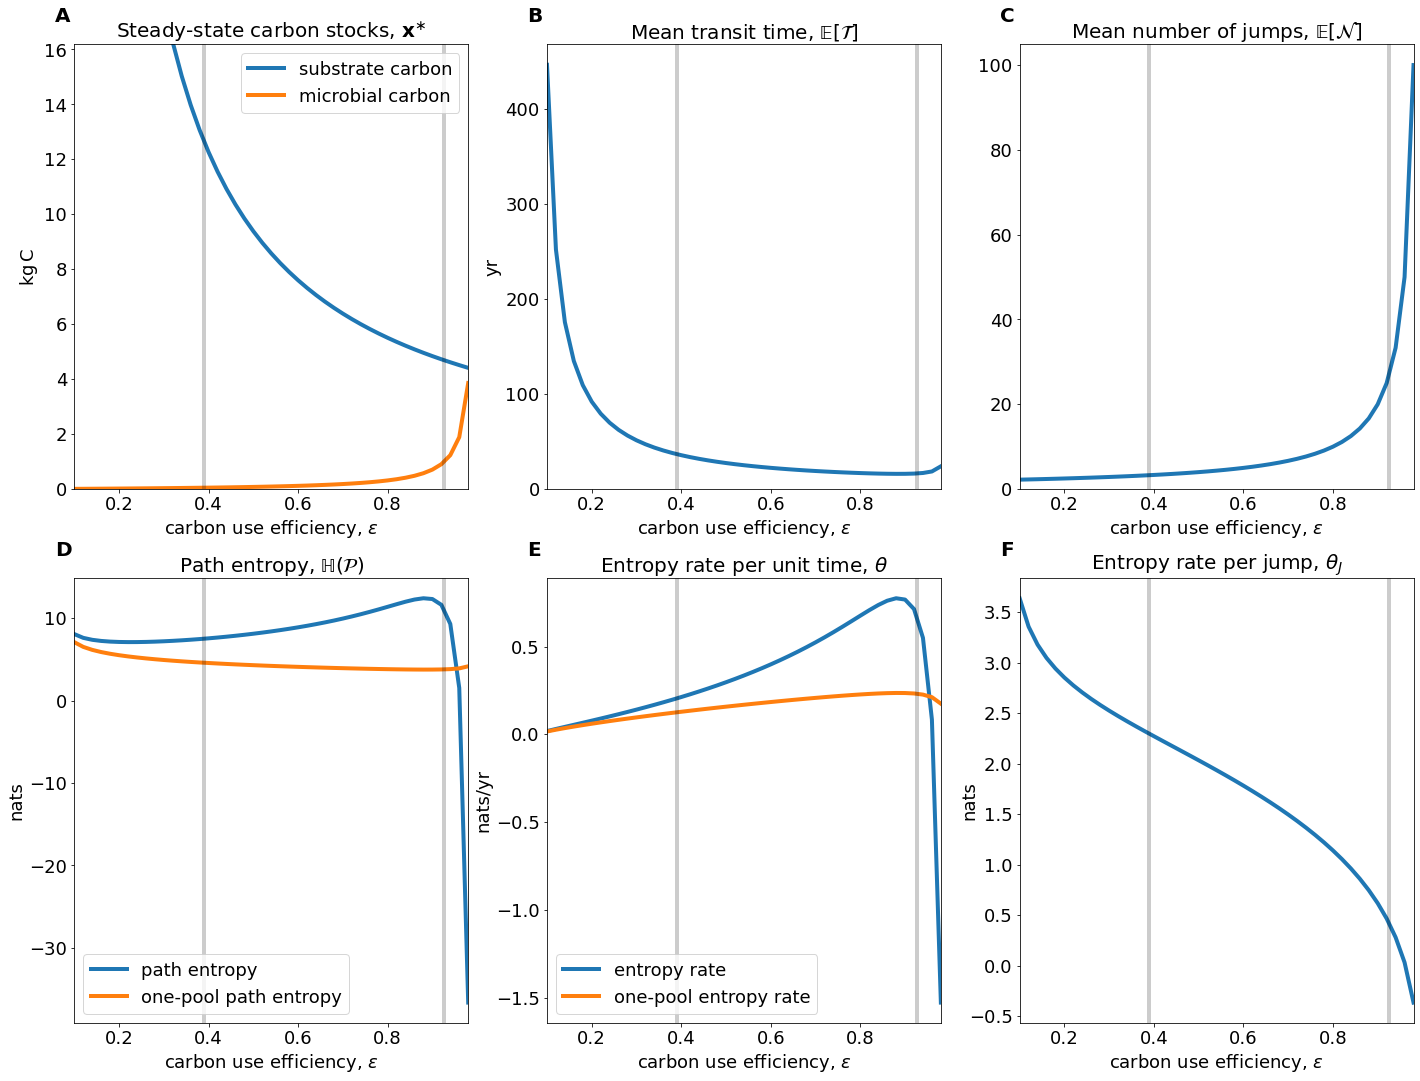

In [94]:
fix, axes = plt.subplots(figsize=(8*3, 6*3), nrows=2, ncols=3)
axes_list = axes.flatten()
panel_names = iter(string.ascii_uppercase[:len(axes_list)])
[ax.set_xlabel(r"carbon use efficiency, $\varepsilon$") for ax in axes_list]

axes = iter(axes_list)

ax = next(axes)
ax.set_title(r"Steady-state carbon stocks, $\mathbf{x}^{\ast}$")
lines = ax.plot(epsilons, np.array(xsss)*1e-03)
ax.legend(lines, pool_names)
ax.set_ylim([0, ax.get_ylim()[1]/10])
ax.set_ylabel("kg$\,$C")


ax = next(axes)
ax.set_title(r"Mean transit time, $\mathrm{\mathbb{E}}\left[\mathcal{T}\right]$")
ax.plot(epsilons, ETs)
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
ax.set_ylabel("yr")


ax = next(axes)
ax.set_title(r"Mean number of jumps, $\mathrm{\mathbb{E}}\left[\mathcal{N}\right]$")
ax.plot(epsilons, ENs)
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])


ax = next(axes)
ax.set_title(r"Path entropy, $\mathrm{\mathbb{H}}(\mathcal{P})$")
ax.plot(epsilons, path_entropies, label="path entropy")
ax.plot(epsilons, exp_Hs, label="one-pool path entropy")
ax.legend()
ax.set_ylabel("nats")


ax = next(axes)
ax.set_title(r"Entropy rate per unit time, $\theta$")
ax.plot(epsilons, thetas, label="entropy rate")
ax.plot(epsilons, np.array(exp_Hs)/np.array(ETs), label="one-pool entropy rate")
ax.legend()
ax.set_ylabel("nats/yr")


ax = next(axes)
ax.set_title(r"Entropy rate per jump, $\theta_J$")
ax.plot(epsilons, theta_Ns)
ax.set_ylabel("nats", labelpad=-10)

for ax, panel_name in zip(axes_list, panel_names):
    ax.set_xlim([min(epsilons), max(epsilons)])
    ax.axvline(0.39, color="black", alpha=0.2)
    ax.axvline(0.926, color="black", alpha=0.2)
    ax.text(-0.05, 1.05, panel_name, transform=ax.transAxes, size=20, weight='bold')

## Identify CUE such that `B[0,0] = 1` (max. entrop rate per unit time in C_S)

In [79]:
def g(eps):
    par_dict_extended_epsilon = par_dict_extended.copy()
    par_dict_extended_epsilon['epsilon'] = float(eps)
    return -float(B[0,0].subs(par_dict_extended_epsilon)) - 1

In [80]:
from scipy.optimize import root

In [81]:
root(g, 0.5)

    fjac: array([[-1.]])
     fun: 9.992007221626409e-15
 message: 'The solution converged.'
    nfev: 23
     qtf: array([2.27066188e-09])
       r: array([-14.76423765])
  status: 1
 success: True
       x: array([0.92642229])

In [86]:
np.argmin(np.diff(np.diff(np.array(theta_Ns))) > 0)

17

In [90]:
epsilons[17]

0.44000000000000006